In [47]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import random
import time

# PROBLEM A : Genetic Algorithm for Optimizing a Neural Network

## 1: Dataset Creation

In [48]:
X, y = make_blobs(centers=2, n_features=4)

In [49]:
print(X)

[[-7.82121188 10.21216714 -0.38433606  4.00260026]
 [-4.63242991 -2.54762766 -5.25716199  2.06229474]
 [-6.81340236  8.97933212 -0.50527416  3.96732212]
 [-7.01267861 10.40881835  0.98423288  1.44791827]
 [-6.21444882 -4.8361909  -5.97171749  1.69435606]
 [-8.25258881  9.50006257  0.4439847   2.09083744]
 [-7.96038344  9.98938698 -0.05863371  3.90474132]
 [-5.771248    9.47188649  1.12319695  3.89473952]
 [-7.08297784 11.8396552  -1.16888598  2.58366117]
 [-5.65864699 -3.75111365 -4.0123749   2.22576668]
 [-4.88888806 -3.27256028 -5.46577944  1.01743171]
 [-6.22483156 -2.35052697 -6.06131461  2.6277305 ]
 [-3.61031175 -4.00232459 -5.84152666  0.33156265]
 [-7.44778686 -4.65167318 -3.93373169 -0.07820291]
 [-7.82560354  8.31456775  1.37257649  4.68013414]
 [-5.46121888 -3.14899929 -4.75767471  1.30756273]
 [-7.36486772 -2.04046811 -4.80729667  2.25615325]
 [-5.20463706 -3.21284524 -5.66316345  0.5541686 ]
 [-8.77142474  9.88452991  0.14861601  0.59045342]
 [-6.36072122  9.08025949  0.25

In [50]:
print(y)

[0 1 0 0 1 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1
 0 1 0 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 0 0 1 1 0 1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1]


## 2 : Neural Network Design

In [51]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [52]:

# Define the model architecture
def create_model():
    model = Sequential([
        Dense(16, input_shape=(4,), activation='sigmoid'),  # Input layer + First hidden layer with sigmoid
        Dense(16, activation='sigmoid'),                    # Second hidden layer with sigmoid
        Dense(1, activation='sigmoid')                      # Output layer with sigmoid
    ])
    # We use the MSE as asked after
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
    # Display the model architecture
    return model

model_test = create_model()
model_test.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369 (1.44 KB)

 Trainable params: 369 (1.44 KB)

 Non-trainable params: 0 (0.00 B)

## 3 : GA Implementation

Let's create our class Genetic algorithm that will contains all functions

In [53]:
class GeneticAlgorithm:
    
    def __init__(self, model, X_train, y_train):
        self.model = model
        
    def sigmoid(self,x):
        """
        sigmoid : f(x) = 1 / (1 + exp(-x)).
        """
        return 1 / (1 + np.exp(-x))

    # We created this functions because the one from Tensor Flow was taking too_long
    def predict(self,X):
        """
        Predict the outpus using sigmoid

        INPUT:
            X: The Input for the neurol network

        OUTPUT
            The prediction (numpy array)
        """
        # Récupérer les poids et biais des couches du modèle
        weights_1, biases_1 = self.model.layers[0].get_weights()  # Première couche
        weights_2, biases_2 = self.model.layers[1].get_weights()  # Deuxième couche
        weights_3, biases_3 = self.model.layers[2].get_weights()  # Troisième couche (sortie)

        # Propagation avant
        # Étape 1 : Entrée -> Première couche
        layer_1 = self.sigmoid(np.dot(X, weights_1) + biases_1)

        # Étape 2 : Première couche -> Deuxième couche
        layer_2 = self.sigmoid(np.dot(layer_1, weights_2) + biases_2)

        # Étape 3 : Deuxième couche -> Sortie
        output = self.sigmoid(np.dot(layer_2, weights_3) + biases_3)

        return output


    def update_model(self,individual):
        """
        Sets the model weights based on the individual's parameters
        """
        weights = self.model.get_weights()
        weight_idx = 0
        new_weights = []
        
        for w in weights:
            weight_size = np.prod(w.shape)
            poids_inter = np.array(individual[weight_idx:weight_idx + weight_size])
            new_weights.append(poids_inter.reshape(w.shape))
            weight_idx += weight_size
        
        self.model.set_weights(new_weights)
    
    def initialize_population(self, population_size, num_parameters):
        """
        Initializes a population of individuals.
        Each individual is an array of randomly initialized parameters.
        """
        population = []
        for _ in range(population_size):
            individual = np.random.randn(num_parameters)  # Normal distribution
            population.append(individual)
        return population

    def fitness(self, individual,X,y):
        """
        evaluates fitness using MSE.
        """
        self.update_model(individual)
        
        #
        y_pred = self.predict(X)
        loss = np.mean((y - y_pred.squeeze()) ** 2)

        '''
        Taking too long 

        self.update_model(individual)
        # Evaluate fitness based on MSE
        loss, _ = self.model.evaluate(self.X_train, self.y_train, verbose=0)
        '''
        
        return loss
    
    def Tournament(self, T, k, T_fitness):
        """
        INPUT
            T = a list of individuals randomly selected from a population.
            Fitness = list of the fitness of all indivuals
            k = the tournament size. In other words, the number of elements in T.
        OUTPUT
            the fittest individual.
        """
        best = T[0]
        best_fitness = T_fitness[0]
        for i in range(1, k):
            if T_fitness[i] < best_fitness:
                best = T[i]
                best_fitness = T_fitness[i]
        return best

    def Tournament_Selection(self, P, k, n,fitness):
        """
        INPUT
            P = The population
            k = the tournament size, such that 1 ≤ k ≤ the number of individuals in P.
            n = the total number of individuals we wish to select.
        OUTPUT
            a list with tournament winners
        """
        B = []
        for i in range(n):
            indices = random.sample(range(len(P)), k)
            T = [P[idx] for idx in indices]
            T_fitness = [fitness[idx] for idx in indices]
            B.append(self.Tournament(T, k, T_fitness))
        return B

    def Two_Points_crossover(self, individu1, individu2, n):
        """
        INPUT 
            n = size of individuals
            individu1 = first individual
            individu2 = second individual
        OUTPUT 
            two new individuals
        """
        point1, point2 = sorted(np.random.randint(1, n - 1, 2))

        new_individual1 = np.concatenate((individu1[:point1], individu2[point1:point2], individu1[point2:]))
        new_individual2 = np.concatenate((individu2[:point1], individu1[point1:point2], individu2[point2:]))
        
        return new_individual1, new_individual2
    
    def apply_crossover(self,individuals,n):
        """
        INPUT 
            indivuals = all our indivual
            n = size of individuals
        OUTPUT 
           list with the new_individuals
        """
        new_individual=[]
        for i in range(0,n-1,2):
            new_individual1, new_individual2 = self.Two_Points_crossover(individuals[i],individuals[i+1],n)
            new_individual.append(new_individual1)
            new_individual.append(new_individual2)
        return new_individual

    def swap_mutation(self, individu, mutation_rate=0.1):
        """
        INPUT 
            individu = individual we want to analyse
            mutation_rate = rate if we want to aply our mutation on the individual
        OUTPUT
            a new individual using swap mutation
        """
        if np.random.rand() < mutation_rate:
            index1, index2 = np.random.choice(len(individu), 2, replace=False)
            individu[index1], individu[index2] = individu[index2], individu[index1]
        return individu
    
    def apply_mutation(self,individus,n,mutation_rate=0.1):
        """
        INPUT 
            individus = list of individual we want to analyse
            n = size of individuals
            mutation_rate = rate if we want to aply our mutation on the individual
        OUTPUT
            a new individual using swap mutation
        """
        new_individu=[]
        for i in range(n):
            new_individu.append(self.swap_mutation(individus[i],mutation_rate))
        return new_individu
    
    def sort_population(self,population, fitness_scores):

        """
        Other way

        sorted_population_with_fitness = sorted(zip(fitness_scores, population), key=lambda pair: pair[0])
        # sort the population by their fitness
        sorted_population = [indiv for _, indiv in sorted_population_with_fitness]
        # sort the fitness
        sorted_fitness_scores = [fitness for fitness, _ in sorted_population_with_fitness]
        """
        indices = np.argsort(fitness_scores)
        sorted_population = [population[i] for i in indices]
        sorted_fitness_scores = [fitness_scores[i] for i in indices]
        
        return sorted_population, sorted_fitness_scores



## 4 : GA Parameters:

In [54]:
population_size = 100
numbers_of_generations = 200
num_parameters = 369
mutation_rate=0.1
tournament_size = 5
elitism_count = 10  # Keep top 10 solutions

## 5 : Optimization Process:

In [55]:
from datetime import datetime
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = create_model()
GA = GeneticAlgorithm(model,X_train,y_train)


best_mse_per_generation_train = []
best_mse_per_generation_test = []
population=GA.initialize_population(population_size,num_parameters)
for generation in range(numbers_of_generations):
    # Step 1: Evaluate fitness for each individual for the elitism function
    fitness_values = [GA.fitness(indivual,X_train,y_train) for indivual in population]

    # Sort individuals
    sorted_population,sorted_fitness = GA.sort_population(population,fitness_values)

    # Step 3 : Select the 10 best individuals in the population
    elites = sorted_population[:elitism_count]
    # Step 2: Perform tournament selection 
    # We apply it only on the 90th others individuals
    tournament_winners = GA.Tournament_Selection(sorted_population[elitism_count:], tournament_size, population_size - elitism_count,sorted_fitness[elitism_count:])
    # Step 3: Apply crossover and mutation
    crossover_population = GA.apply_crossover(tournament_winners, len(tournament_winners))
    mutated_population = GA.apply_mutation(crossover_population, len(crossover_population), mutation_rate)
    
    # Step 4: Create a new generation with 10th whoose with elitism and the others
    population = elites+mutated_population

    # We compute the fitness for test using the best population we found for train
    fitness_test = GA.fitness(elites[0],X_test,y_test)

    print(f"Generation {generation + 1}: Best fitness {sorted_fitness[0]} for train, fitness {fitness_test} for test")

    best_mse_per_generation_train.append(sorted_fitness[0])
    best_mse_per_generation_test.append(fitness_test)
    
    GA.update_model(sorted_population[0]) # Because it's ask to update it at each generation even if it will be change in the next generation
    
    


Generation 1: Best fitness 0.09109437474686773 for train, fitness 0.0867540181549066 for test
Generation 2: Best fitness 0.07167893941008747 for train, fitness 0.07620866260799988 for test
Generation 3: Best fitness 0.07167893941008747 for train, fitness 0.07620866260799988 for test
Generation 4: Best fitness 0.0414831029328656 for train, fitness 0.039598248046748885 for test
Generation 5: Best fitness 0.0327163474961755 for train, fitness 0.03447103863979561 for test
Generation 6: Best fitness 0.0327163474961755 for train, fitness 0.03447103863979561 for test
Generation 7: Best fitness 0.030204536563112984 for train, fitness 0.02815612563428352 for test
Generation 8: Best fitness 0.011121992602118746 for train, fitness 0.009504218280373813 for test
Generation 9: Best fitness 0.011121992602118746 for train, fitness 0.009504218280373813 for test
Generation 10: Best fitness 0.011121992602118746 for train, fitness 0.009504218280373813 for test
Generation 11: Best fitness 0.011121992602118

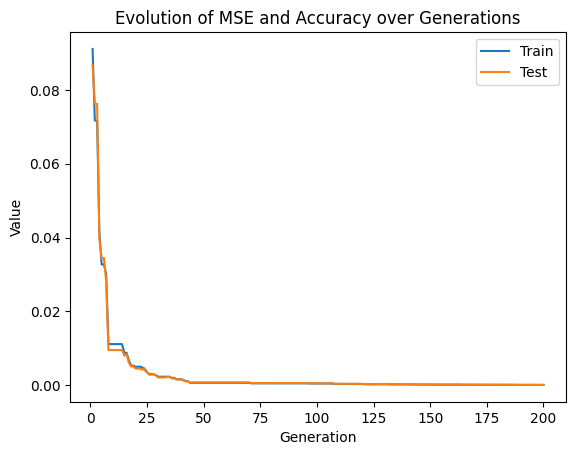

In [56]:
import matplotlib.pyplot as plt

# Affichage de la première courbe (par exemple, MSE)
plt.plot(range(1, numbers_of_generations + 1), best_mse_per_generation_train, label='Train')

# Affichage de la deuxième courbe (par exemple, une autre métrique, ici "accuracy")
plt.plot(range(1, numbers_of_generations + 1), best_mse_per_generation_test, label='Test')

# Ajouter des légendes pour différencier les courbes
plt.xlabel("Generation")
plt.ylabel("Value")
plt.title("Evolution of MSE and Accuracy over Generations")

# Afficher la légende pour identifier chaque courbe
plt.legend()

# Affichage du graphique
plt.show()



We can see that the model perform really good on the train and also on the test. Thus there is no overfitting.

## 6 : Discussion

We are going to try to use the traditional methods and compare the results

To do that we create a new function callback that will allow to print the mse for each epoch of the train and the test

In [57]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

class TrainTestPerformanceCallback(Callback):
    def __init__(self, X_train, y_train, X_test, y_test):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    def on_epoch_end(self, epoch, logs=None):
        # Calculer la performance sur les données d'entraînement
        train_loss,_ = self.model.evaluate(self.X_train, self.y_train, verbose=0)
        
        # Calculer la performance sur les données de test
        test_loss,_ = self.model.evaluate(self.X_test, self.y_test, verbose=0)
        
        # Afficher les résultats
        print(f"Epoch {epoch + 1}: mse = {train_loss} for train, mse = {test_loss} for test")


In [58]:
model2 = create_model()
performance_callback = TrainTestPerformanceCallback(X_train, y_train, X_test, y_test)

# Entraîner le modèle avec la callback
model2.fit(X_train, y_train, epochs=200, validation_split=0.2, verbose=0, callbacks=[performance_callback])

Epoch 1: mse = 0.23897747695446014 for train, mse = 0.26697468757629395 for test
Epoch 2: mse = 0.2363714724779129 for train, mse = 0.2623763978481293 for test
Epoch 3: mse = 0.23393180966377258 for train, mse = 0.2581613063812256 for test
Epoch 4: mse = 0.23156261444091797 for train, mse = 0.2539840340614319 for test
Epoch 5: mse = 0.22929927706718445 for train, mse = 0.25003498792648315 for test
Epoch 6: mse = 0.22710900008678436 for train, mse = 0.24622742831707 for test
Epoch 7: mse = 0.224982351064682 for train, mse = 0.24256446957588196 for test
Epoch 8: mse = 0.22291946411132812 for train, mse = 0.2391178160905838 for test
Epoch 9: mse = 0.22090300917625427 for train, mse = 0.23567180335521698 for test
Epoch 10: mse = 0.21897146105766296 for train, mse = 0.2326829433441162 for test
Epoch 11: mse = 0.21705901622772217 for train, mse = 0.22977972030639648 for test
Epoch 12: mse = 0.21515598893165588 for train, mse = 0.22675995528697968 for test
Epoch 13: mse = 0.21327140927314758 

As we can see the traditionnal methods is 2 times faster than the GA methods, 
for 200 generations :
Traditional=> 53 seconds
GA=> 1 minute and  40seconds

the accuracy of the GA algorithms is 100 times better, 
for 200 generations : 
Traditional=> 6.5e-03
GA=> 6.5e-05

Thus the genetic algorithm is a better options for this problem